<a href="https://colab.research.google.com/github/FujiminoDeliaMary/ArtfullCode/blob/main/BigDataAI/TP2_nonsupervise_pays.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP 2 : Réduction de dimensionnalité et clustering
Importation des librairies

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import time

# Vérification du dossier courant
import os
print(os.getcwd())

np.set_printoptions(precision=3,suppress=True, threshold=5) # 3 décimales, pas de notation scientifique, affichage de 5 lignes
print(f"Numpy {np.__version__}, Pandas {pd.__version__}")

/content
Numpy 1.26.4, Pandas 2.2.2


# 1/ Réduction des dimensionnalité : PCA et Clustering

1.1 Charger le fichier world-data-2023 dans un dataframe. Afficher les 3 premières lignes.

In [2]:
from google.colab import drive

drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/brut-world-data-2023.csv'

df = pd.read_csv(file_path)
df.head(3)

Mounted at /content/drive


,Country,Density\n(P/Km2),Abbreviation,Agricultural Land( %),Land Area(Km2),Armed Forces size,Birth Rate,Calling Code,Capital/Major City,Co2-Emissions,...,Out of pocket health expenditure,Physicians per thousand,Population,Population: Labor force participation (%),Tax revenue (%),Total tax rate,Unemployment rate,Urban_population,Latitude,Longitude
0,Afghanistan,60,AF,58.10%,"652,230","323,000",32.49,93.0,Kabul,"8,672",...,78.40%,0.28,"38,041,754",48.90%,9.30%,71.40%,11.12%,"9,797,273",33.939110,67.709953
1,Albania,105,AL,43.10%,"28,748","9,000",11.78,355.0,Tirana,"4,536",...,56.90%,1.20,"2,854,191",55.70%,18.60%,36.60%,12.33%,"1,747,593",41.153332,20.168331
2,Algeria,18,DZ,17.40%,"2,381,741","317,000",24.28,213.0,Algiers,"150,006",...,28.10%,1.72,"43,053,054",41.20%,37.20%,66.10%,11.70%,"31,510,100",28.033886,1.659626


1.2 Normaliser les données numériques, puis remplacer les valeurs Nan par la valeur 0, en utilisant la fonction np.isnan().

In [3]:
from sklearn.preprocessing import StandardScaler

#Sélectionner les colonnes numériques
numeric_cols = df.select_dtypes(include=[np.number]).columns


df[numeric_cols] = StandardScaler().fit_transform(df[numeric_cols])
df.fillna(0, inplace=True)



1.3 Appliquer une PCA aux données normalisée, afin d'obtenir une réprésentation en deux dimensions.
En utilisant time, mesure le temps d'éxécution.

In [7]:
from sklearn.decomposition import PCA

#Début du chrono
start_time = time.time()

pca = PCA(n_components=2)
pca_result = pca.fit_transform(df[numeric_cols])

# Fin du chrono
end_time = time.time()

df_pca = pd.DataFrame(pca_result, columns=["PC1", "PC2"])

print(f"Temps d'exécution : + {end_time - start_time:.4f} secondes");

Temps d'exécution : + 0.0091 secondes


1.4 Afficher la variance expliquée par les deux axes de la PCA

In [8]:
explained_variance = pca.explained_variance_ratio_
print(f"Variance expliquée par le premier axe : {explained_variance[0]:.4f}")
print(f"Variance expliquée par le deuxième axe : {explained_variance[1]:.4f}")

Variance expliquée par le premier axe : 0.5762
Variance expliquée par le deuxième axe : 0.1389


1.5 Appliquer T-SNE à ces même données toujours en deux dimensions et en affichant le temps de traitement

In [9]:
from sklearn import manifold

start_time = time.time()

tsne = manifold.TSNE(n_components=2, random_state=0)
tsne_result = tsne.fit_transform(df[numeric_cols])

end_time = time.time()

print(f"Temps de traitement: + {end_time - start_time:.4f} secondes");

Temps de traitement: + 3.7439 secondes


1.6 Créer deux diagrammes côte côte représentant les pays en 2D suivant les deux algorithmes. Ajouter les noms de pays à chaque point.
Essayer plusieurs paramètres de t-nse pour obtenir un résultat interprétable

TypeError: list indices must be integers or slices, not tuple

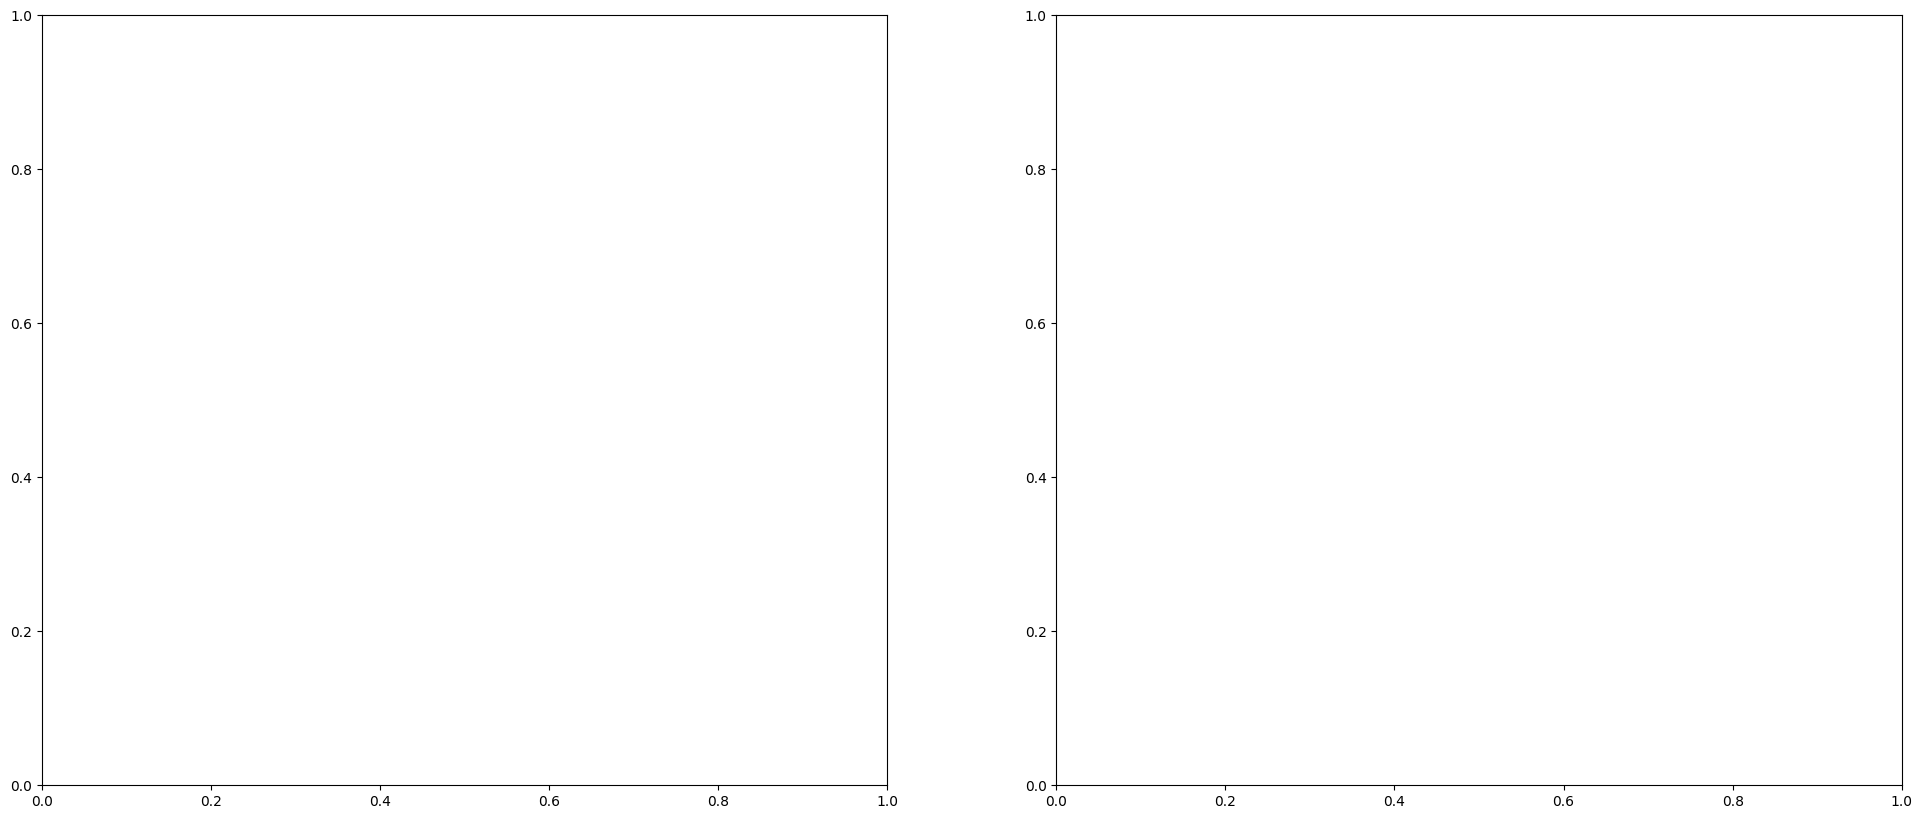

In [10]:
df_countries = pd.DataFrame() # Remplacer par les données chargées en 1.1
countries_tsne = [] # Remplacer par le résultat de votre t-SNE
countries_pca  = [] # Remplacer par le résultat de votre pca

# Création du double graphique
fig, axs = plt.subplots(1, 2, figsize=(24, 10))  # 1 ligne, 2 colonnes

# Graphique TSNE
axs[0].scatter(countries_tsne[:, 0], countries_tsne[:, 1], color='blue')
# Ajout des labels
for i, label in enumerate(df_countries.Pays): # Abréviation
    axs[0].annotate(label, (countries_tsne[i, 0], countries_tsne[i, 1]), textcoords="offset points", xytext=(0,10), fontsize = 8, ha='center')
# Ajout des titres et des axes
axs[0].set_title("Pays (TSNE)")
axs[0].set_xlabel("Axe X")
axs[0].set_ylabel("Axe Y")
axs[0].grid()

# Graphique PCA
axs[1].scatter(countries_pca[:, 0], countries_pca[:, 1], color='blue')
# Ajout des labels
for i, label in enumerate(df_countries.Pays): # Abréviation
    axs[1].annotate(label, (countries_pca[i, 0], countries_pca[i, 1]), textcoords="offset points", xytext=(0,10), fontsize = 8, ha='center')
# Ajout des titres et des axes
axs[1].set_title("Pays (PCA)")
axs[1].set_xlabel("Axe X")
axs[1].set_ylabel("Axe Y")
axs[1].grid()

# Afficher le graphique
plt.show()

# 2. Application de K-Means

2.1 Déterminer le nombre de cluster k-means optimal sur les données initiales normalisées, en traçant une courbe

In [ ]:
from sklearn.cluster import KMeans


2.2 Appliquer l'algorithme k-means aux données initiales normalisées, en utilisant le nombre de cluster optimal

Afficher le temps de traitement

2.3 Afficher les pays pour chaque cluster

2.4 Tracer en 2D avec t-sne et pca les données avec une couleur par cluster k-means.

In [ ]:
df_countries = pd.DataFrame() # Remplacer par les données chargées en 1.1
countries_tsne = [] # Remplacer par le résultat de votre t-SNE
countries_pca  = [] # Remplacer par le résultat de votre pca
clusters_kmeans = [] # Remplacer par le résultat de votre kmeans (numéro de cluster)

# Liste de couleurs à utiliser pour les clusters (une couleur par cluster)
colors = ['red', 'blue', 'green', 'purple', 'orange']

# Création du double graphique
fig, axs = plt.subplots(1, 2, figsize=(24, 10))  # 1 ligne, 2 colonnes

# Graphique TSNE
for cluster_value in np.unique(clusters_kmeans):
    cluster_points = countries_tsne[clusters_kmeans == cluster_value]
    axs[0].scatter(cluster_points[:, 0], cluster_points[:, 1], color=colors[cluster_value], label=f'Cluster {cluster_value}')
# Ajout des labels
for i, label in enumerate(df_countries.Pays):
    axs[0].annotate(label, (countries_tsne[i, 0], countries_tsne[i, 1]), textcoords="offset points", xytext=(0,10), fontsize = 8, ha='center')
# Ajout des titres et des axes
axs[0].set_title("Pays (TSNE)")
axs[0].set_xlabel("Axe X")
axs[0].set_ylabel("Axe Y")
axs[0].grid()

# Graphique PCA
for cluster_value in np.unique(clusters_kmeans):
    cluster_points = countries_pca[clusters_kmeans == cluster_value]
    axs[1].scatter(cluster_points[:, 0], cluster_points[:, 1], color=colors[cluster_value], label=f'Cluster {cluster_value}')
# Ajout des labels
for i, label in enumerate(df_countries.Pays):
    axs[1].annotate(label, (countries_pca[i, 0], countries_pca[i, 1]), textcoords="offset points", xytext=(0,10), fontsize = 8, ha='center')
# Ajout des titres et des axes
axs[1].set_title("Pays (PCA)")
axs[1].set_xlabel("Axe X")
axs[1].set_ylabel("Axe Y")
axs[1].grid()

# Afficher le graphique
plt.legend()
plt.show()

2.5 Réafficher La projection PCA en excluant les plus grands pays : China, United States, India, Russia

Interpréter les axes X et Y de la PCA.

In [ ]:
df_countries = pd.DataFrame() # Remplacer par les données chargées en 1.1
countries_pca  = [] # Remplacer par le résultat de votre pca
clusters_kmeans = [] # Remplacer par le résultat de votre kmeans (numéro de cluster)

excluded_countries = ['China','United States','India','Russia']
countries_filtered = countries_pca[~df_countries.Pays.isin(excluded_countries)]
plt.figure(figsize=(12, 10))
for cluster_value in np.unique(clusters_kmeans):
    cluster_points = countries_filtered[df_countries.loc[~df_countries.Pays.isin(excluded_countries),'cluster'] == cluster_value]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], color=colors[cluster_value-1], label=f'Cluster {cluster_value}')
# Ajout des labels
for i, label in enumerate(df_countries.loc[~df_countries.Pays.isin(excluded_countries),'Pays']):
    plt.annotate(label, (countries_filtered[i, 0], countries_filtered[i, 1]), textcoords="offset points", xytext=(0,10), fontsize = 8, ha='center')
# Ajout des titres et des axes
plt.title("Pays (PCA)")
plt.xlabel("Axe X")
plt.ylabel("Axe Y")
plt.grid()

# Afficher le graphique
plt.legend()
plt.show()

# 3. Application de CAH

3.1 Importation des librairies

In [ ]:
from sklearn.metrics import accuracy_score # Calcul du score de bonnes réponses
from scipy.spatial.distance import pdist # Fonction scipy de création de la CAH de calcul des distances
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster # Fonction scipy de création de la CAH

3.2 Afficher la matrice de linkage des données de pays

Mesurer le temps de traitement

3.3 Afficher horizontalement le dentogramme complet.

Mesurer le temps de traitement

3.4 Afficher les 4 niveaux supérieurs du dentogramme

3.5 Trouver le nombre optimal de cluster CAH

3.6 Diviser selon le nombre optimal de cluster obtenu. Afficher la liste de pays de chaque cluster.

3.7 Tracer en 2D avec t-sne et pca les données avec une couleur par cluster CAH.

In [ ]:
df_countries = pd.DataFrame() # Remplacer par les données chargées en 1.1
countries_tsne = [] # Remplacer par le résultat de votre t-SNE
countries_pca  = [] # Remplacer par le résultat de votre pca
clusters_cah = [] # Remplacer par le résultat de votre CAH (numéro de cluster)

# Liste de couleurs à utiliser pour les clusters (une couleur par cluster)
colors = ['red', 'blue', 'green', 'purple', 'orange']

# Création du double graphique
fig, axs = plt.subplots(1, 2, figsize=(24, 10))  # 1 ligne, 2 colonnes

# Graphique TSNE
for cluster_value in np.unique(clusters_cah):
    cluster_points = countries_tsne[clusters_cah == cluster_value]
    axs[0].scatter(cluster_points[:, 0], cluster_points[:, 1], color=colors[cluster_value-1], label=f'Cluster {cluster_value}')
# Ajout des labels
for i, label in enumerate(df_countries.Pays):
    axs[0].annotate(label, (countries_tsne[i, 0], countries_tsne[i, 1]), textcoords="offset points", xytext=(0,10), fontsize = 8, ha='center')
# Ajout des titres et des axes
axs[0].set_title("Pays (TSNE)")
axs[0].set_xlabel("Axe X")
axs[0].set_ylabel("Axe Y")
axs[0].grid()

# Graphique PCA
for cluster_value in np.unique(clusters_cah):
    cluster_points = countries_pca[clusters_cah == cluster_value]
    axs[1].scatter(cluster_points[:, 0], cluster_points[:, 1], color=colors[cluster_value-1], label=f'Cluster {cluster_value}')
# Ajout des labels
for i, label in enumerate(df_countries.Pays):
    axs[1].annotate(label, (countries_pca[i, 0], countries_pca[i, 1]), textcoords="offset points", xytext=(0,10), fontsize = 8, ha='center')
# Ajout des titres et des axes
axs[1].set_title("Pays (PCA)")
axs[1].set_xlabel("Axe X")
axs[1].set_ylabel("Axe Y")
axs[1].grid()

# Afficher le graphique
plt.legend()
plt.show()

3.8 Afficher la projection PCA en retirant les plus grands pays : China, United States, India et Russia

In [ ]:
df_countries = pd.DataFrame() # Remplacer par les données chargées en 1.1
countries_pca  = [] # Remplacer par le résultat de votre pca
clusters_cah = [] # Remplacer par le résultat de votre CAH (numéro de cluster)

excluded_countries = ['China','United States','India','Russia']
countries_filtered = countries_pca[~df_countries.Pays.isin(excluded_countries)]
plt.figure(figsize=(12, 10))
for cluster_value in np.unique(clusters_cah):
    cluster_points = countries_filtered[df_countries.loc[~df_countries.Pays.isin(excluded_countries),'cluster'] == cluster_value]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], color=colors[cluster_value-1], label=f'Cluster {cluster_value}')
# Ajout des labels
for i, label in enumerate(df_countries.loc[~df_countries.Pays.isin(excluded_countries),'Pays']):
    plt.annotate(label, (countries_filtered[i, 0], countries_filtered[i, 1]), textcoords="offset points", xytext=(0,10), fontsize = 8, ha='center')
# Ajout des titres et des axes
plt.title("Pays (PCA)")
plt.xlabel("Axe X")
plt.ylabel("Axe Y")
plt.grid()

# Afficher le graphique
plt.legend()
plt.show()

3.9 Quels sont les avantages et inconvénient entre les différentes combinaisons de réduction de dimensionnalité (PCA, t-SNE) et de clustering (k-Means, CAH) ?

<i>écrivez votre réponse ici</i>